In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from math import sqrt
import pandas as pd
import numpy as np

bike_data_raw = pd.read_csv('daily-bike-share.csv')
bike_data_raw['dteday'] = pd.to_datetime(bike_data_raw['dteday'])
bike_data = bike_data_raw.copy()
bike_data.drop(['instant', 'dteday', 'yr'], axis=1, inplace=True)

numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season','mnth','holiday','weekday','workingday','weathersit']
target = 'rentals'

# Podział na zmienne objaśniające i zmienną objaśnianą
X = bike_data[numeric_features+categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiór treningowy i testowy (taki sam podział co poprzednio)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
params = {'polynomialfeatures__degree': [1, 2, 3, 4, 5]}
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Tworzenie końcowego Pipeline, który będziemy trenować
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('regressor', ElasticNet())])

params = {'preprocessor__num__polynomialfeatures__degree': [1, 2, 3, 4, 5],
          'regressor__alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 0.0, 1.0, 10.0, 100.0],
          'regressor__l1_ratio': np.arange(0, 1.1, 0.1)}
cv = KFold(n_splits=5, shuffle=False)
final_polynomial_regression_gridsearch = GridSearchCV(final_pipeline,
                                                      params,
                                                      scoring='neg_mean_squared_error',
                                                      cv=cv)
final_polynomial_regression_gridsearch.fit(X_train, y_train)


final_polynomial_regression_model = final_polynomial_regression_gridsearch.best_estimator_
predictions_test = final_polynomial_regression_model.predict(X_test)
predictions_train = final_polynomial_regression_model.predict(X_train)



In [16]:
print("\nNajlepsze hiperparametry:", final_polynomial_regression_gridsearch.best_params_, "\n")
print(f'RMSE: {np.sqrt(mean_squared_error(y_test, predictions))}')


Najlepsze hiperparametry: {'preprocessor__num__polynomialfeatures__degree': 3, 'regressor__alpha': 0.1, 'regressor__l1_ratio': np.float64(0.8)} 

RMSE: 443.2085963865407


In [22]:
print(f'Train R^2: {r2_score(y_train, predictions_train)}')
print(f'Train MAE: {mean_absolute_error(y_train, predictions_train)}')
print(f'Test MAE: {mean_absolute_error(y_test, predictions_test)}')
print(f'Train MAPE: {mean_absolute_percentage_error(y_train, predictions_train)}')
print(f'Test MAPE: {mean_absolute_percentage_error(y_test, predictions_test)}')
print(f'Train MSE: {mean_squared_error(y_train, predictions_train)}')
print(f'Test MSE: {mean_squared_error(y_test, predictions_test)}')
print(f'Train RMSE: {sqrt(mean_squared_error(y_train, predictions_train))}')
print(f'Test RMSE: {sqrt(mean_squared_error(y_test, predictions_test))}')

Train R^2: 0.7602219538441449
Train MAE: 242.22573264687486
Test MAE: 333.50266414836057
Train MAPE: 0.8023294814635433
Test MAPE: 2.1500367016621826
Train MSE: 109809.96659747728
Test MSE: 196433.85991092757
Train RMSE: 331.3758690633301
Test RMSE: 443.2085963865407


## Porownanie reszt

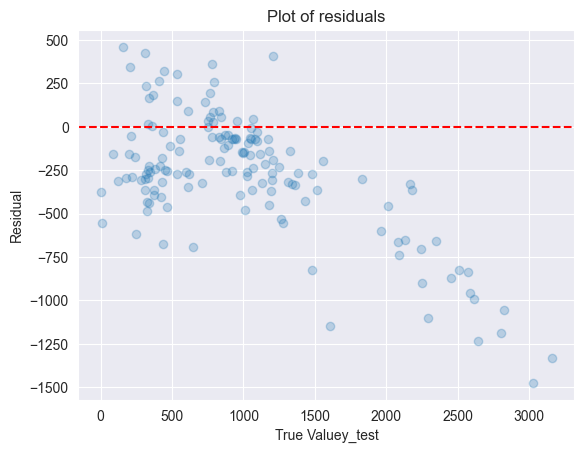

In [24]:
import matplotlib.pyplot as plt
errors = predictions_test - y_test
plt.scatter(x = y_test, y = errors, alpha=0.25)
plt.axhline(0, color="r", linestyle="--")
plt.xlabel('True Valuey_test')
plt.ylabel('Residual')
plt.title(f'Plot of residuals')
plt.show()

### histogram reszt

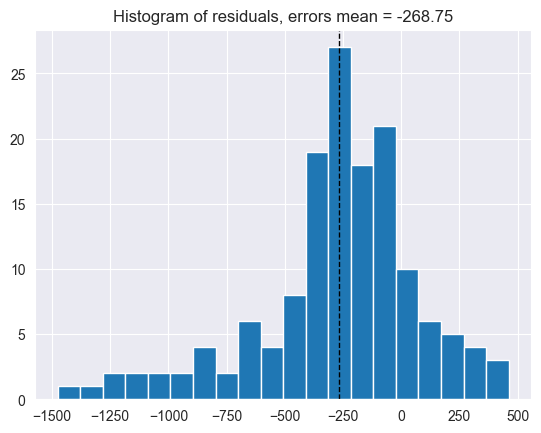

In [25]:
plt.hist(errors, bins = 20)
plt.axvline(errors.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title(f'Histogram of residuals, errors mean = {np.round(errors.mean(), 2)}')
plt.show()